<a href="https://colab.research.google.com/github/nana881023/ML/blob/main/HW4_EmsembleLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Emsemble Learning
- 沿用之前CDC的資料集，請分別使用 SVM 以及 emsemble learning 的方式試圖提高正確率。

### 安裝套件

In [1]:
!nvidia-smi

Sun Dec  1 14:02:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!pip install cudf-cu12 cuml-cu12 cupy-cuda12x

In [2]:
# 安裝必要套件
!pip install ucimlrepo
!pip install imbalanced-learn

導入所需的套件

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf

### 載入數據和評估函數



In [4]:
# 載入數據集
diabetes_dataset = fetch_ucirepo(id=891)
X = diabetes_dataset.data.features.to_numpy()
y = diabetes_dataset.data.targets.to_numpy().ravel()

# 分割數據
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
  """評估模型性能的函數"""
  accuracy = accuracy_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  auc = roc_auc_score(y_true, y_pred_proba)

  print(f"\n{model_name} 評估結果:")
  print(f"準確率: {accuracy:.4f}")
  print(f"MSE: {mse:.4f}")
  print(f"AUC-ROC: {auc:.4f}")
  print("\n分類報告:")
  print(classification_report(y_true, y_pred))

  return {
      'model_name': model_name,
      'accuracy': accuracy,
      'mse': mse,
      'auc': auc,
      'predictions': y_pred,
      'probabilities': y_pred_proba
  }

### HW2

In [14]:
def hw2_method():
  """HW2方法（PCA + RandomForest）"""
  print("\n執行 HW2 方法...")

  # 正規化
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # 特徵選擇
  selector = SelectKBest(f_classif, k=10)
  X_train_selected = selector.fit_transform(X_train_scaled, y_train)
  X_test_selected = selector.transform(X_test_scaled)

  # PCA
  pca = PCA(n_components=0.95)
  X_train_pca = pca.fit_transform(X_train_selected)
  X_test_pca = pca.transform(X_test_selected)

  # SMOTE
  smote = SMOTE(random_state=42)
  X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train)

  # RandomForest
  rf = RandomForestClassifier(random_state=42)
  rf.fit(X_train_balanced, y_train_balanced)

  y_pred = rf.predict(X_test_pca)
  y_pred_proba = rf.predict_proba(X_test_pca)[:, 1]

  return evaluate_model(y_test, y_pred, y_pred_proba, "HW2")

In [15]:
hw2_result = hw2_method()


執行 HW2 方法...

HW2 評估結果:
準確率: 0.7913
MSE: 0.2087
AUC-ROC: 0.7448

分類報告:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88     43739
           1       0.31      0.43      0.36      6997

    accuracy                           0.79     50736
   macro avg       0.61      0.64      0.62     50736
weighted avg       0.82      0.79      0.80     50736



### HW3

In [16]:
def hw3_method():
  """HW3方法（無敏感特徵 + 多項式回歸）"""
  print("\n執行 HW3 方法...")

  # 獲取特徵索引
  feature_names = diabetes_dataset.data.features.columns
  sensitive_indices = [feature_names.get_loc(col) for col in ['Sex', 'Income', 'Education']]
  keep_indices = [i for i in range(X_train.shape[1]) if i not in sensitive_indices]
  X_train_filtered = X_train[:, keep_indices]
  X_test_filtered = X_test[:, keep_indices]

  # SMOTE處理不平衡數據
  smote = SMOTE(random_state=42)
  X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train)

  # 多項式特徵
  poly = PolynomialFeatures(degree=2)
  X_train_poly = poly.fit_transform(X_train_balanced)
  X_test_poly = poly.transform(X_test_filtered)

  # 訓練線性回歸模型
  model = LinearRegression()
  model.fit(X_train_poly, y_train_balanced)
  predictions = model.predict(X_test_poly)

  y_pred = (predictions > 0.5).astype(int)

  return evaluate_model(y_test, y_pred, predictions, "HW3")

In [17]:
hw3_result = hw3_method()


執行 HW3 方法...

HW3 評估結果:
準確率: 0.7107
MSE: 0.2893
AUC-ROC: 0.8053

分類報告:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     43739
           1       0.29      0.77      0.42      6997

    accuracy                           0.71     50736
   macro avg       0.62      0.74      0.62     50736
weighted avg       0.86      0.71      0.75     50736



### SVM方法 (三種配置)

- svm和emsemble數據預處理

In [6]:
# 1. 標準化
print("\n執行數據標準化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. SMOTE平衡數據
print("執行SMOTE處理...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("數據預處理完成:")
print(f"訓練數據形狀: {X_train_balanced.shape}")
print(f"測試數據形狀: {X_test_scaled.shape}")


執行數據標準化...
執行SMOTE處理...
數據預處理完成:
訓練數據形狀: (349190, 21)
測試數據形狀: (50736, 21)


In [10]:
import numpy as np
import cupy as cp  # 添加cupy
from cuml.svm import LinearSVC as cuLinearSVC
from cuml.svm import SVC as cuSVC

def train_svm(kernel_type, C_value, extra_params=None):
  """
  使用GPU加速的SVM訓練（cuML版本）
  如果是線性核函數，使用專門的LinearSVC
  """
  print(f"\n執行 GPU-SVM - {kernel_type}, C={C_value}")

  # 將數據轉移到GPU
  X_train_gpu = cp.asarray(X_train_balanced)
  y_train_gpu = cp.asarray(y_train_balanced)
  X_test_gpu = cp.asarray(X_test_scaled)

  if kernel_type == 'linear':
    # 對線性核函數使用專門的解算器
    svm = cuLinearSVC(C=C_value, probability=True)
  else:
    # 對其他核函數使用標準SVC
    params = {'kernel': kernel_type, 'C': C_value, 'probability': True}
    if extra_params:
      params.update(extra_params)
    svm = cuSVC(**params)

  svm.fit(X_train_gpu, y_train_gpu)

  # 預測（結果需要轉回CPU）
  y_pred = cp.asnumpy(svm.predict(X_test_gpu))
  if kernel_type == 'linear':
    # LinearSVC需要特別處理概率預測
    decision_scores = cp.asnumpy(svm.decision_function(X_test_gpu))
    y_pred_proba = 1 / (1 + np.exp(-decision_scores))
  else:
    y_pred_proba = cp.asnumpy(svm.predict_proba(X_test_gpu)[:, 1])

  return evaluate_model(y_test, y_pred, y_pred_proba, f"GPU_SVM_{kernel_type}_C{C_value}")

In [11]:
svm_linear = train_svm('linear', 1.0)               # 線性核函數


執行 GPU-SVM - linear, C=1.0

GPU_SVM_linear_C1.0 評估結果:
準確率: 0.7267
MSE: 0.2733
AUC-ROC: 0.8258

分類報告:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     43739
           1       0.31      0.78      0.44      6997

    accuracy                           0.73     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.86      0.73      0.77     50736



In [12]:
svm_rbf = train_svm('rbf', 1.0, {'gamma': 'scale'}) # RBF核函數


執行 GPU-SVM - rbf, C=1.0

GPU_SVM_rbf_C1.0 評估結果:
準確率: 0.7506
MSE: 0.2494
AUC-ROC: 0.8111

分類報告:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     43739
           1       0.32      0.73      0.45      6997

    accuracy                           0.75     50736
   macro avg       0.63      0.74      0.64     50736
weighted avg       0.86      0.75      0.78     50736



In [13]:
svm_poly = train_svm('poly', 1.0, {'degree': 2})    # 多項式核函數


執行 GPU-SVM - poly, C=1.0

GPU_SVM_poly_C1.0 評估結果:
準確率: 0.6940
MSE: 0.3060
AUC-ROC: 0.7793

分類報告:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     43739
           1       0.28      0.77      0.41      6997

    accuracy                           0.69     50736
   macro avg       0.61      0.72      0.60     50736
weighted avg       0.86      0.69      0.74     50736



### Ensemble方法 (三種配置)

In [7]:
def train_ensemble(n_estimators, use_svm=True):
  """
  訓練Ensemble模型
  使用已經標準化和平衡後的數據
  """
  print(f"\n執行 Ensemble - trees={n_estimators}, use_svm={use_svm}")

  # 創建基本分類器
  estimators = [
    ('rf', RandomForestClassifier(n_estimators=n_estimators, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=n_estimators, random_state=42))
  ]

  if use_svm:
    estimators.append(('svm', SVC(probability=True, random_state=42)))

  voting_clf = VotingClassifier(estimators=estimators, voting='soft')
  voting_clf.fit(X_train_balanced, y_train_balanced)

  y_pred = voting_clf.predict(X_test_scaled)
  y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

  return evaluate_model(y_test, y_pred, y_pred_proba, f"Ensemble_trees{n_estimators}_svm{use_svm}")


In [8]:
ensemble_50_no_svm = train_ensemble(50, False)


執行 Ensemble - trees=50, use_svm=False

Ensemble_trees50_svmFalse 評估結果:
準確率: 0.8419
MSE: 0.1581
AUC-ROC: 0.8231

分類報告:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     43739
           1       0.43      0.44      0.43      6997

    accuracy                           0.84     50736
   macro avg       0.67      0.67      0.67     50736
weighted avg       0.84      0.84      0.84     50736



In [9]:
ensemble_30_no_svm = train_ensemble(30, False)


執行 Ensemble - trees=30, use_svm=False

Ensemble_trees30_svmFalse 評估結果:
準確率: 0.8361
MSE: 0.1639
AUC-ROC: 0.8210

分類報告:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     43739
           1       0.41      0.46      0.44      6997

    accuracy                           0.84     50736
   macro avg       0.66      0.68      0.67     50736
weighted avg       0.84      0.84      0.84     50736



### 繪製比較圖表

In [27]:
def plot_final_comparison(hw2_result, hw3_result, svm_linear, svm_rbf, svm_poly, ensemble_50_no_svm, ensemble_30_no_svm):
  # 整理SVM結果
  svm_results = {
      'linear': svm_linear,
      'rbf': svm_rbf,
      'poly': svm_poly
  }
  best_svm = max(svm_results.values(), key=lambda x: x['accuracy'])

  # 整理Ensemble結果
  ensemble_results = {
      'ensemble_50_no_svm': ensemble_50_no_svm,
      'ensemble_30_no_svm': ensemble_30_no_svm,
  }
  best_ensemble = max(ensemble_results.values(), key=lambda x: x['accuracy'])

  # 整理最終比較結果
  final_results = {
      'HW2': hw2_result,
      'HW3': hw3_result,
      'Best_SVM': best_svm,
      'Best_Ensemble': best_ensemble
  }

  # 開始繪圖
  fig, axes = plt.subplots(2, 2, figsize=(15, 12))

  # 1. 準確率比較
  accuracies = [result['accuracy'] for result in final_results.values()]
  bars = axes[0, 0].bar(final_results.keys(), accuracies)
  axes[0, 0].set_title('Accuracy Comparison', fontsize=12)
  axes[0, 0].set_ylim(0, 1)
  axes[0, 0].set_ylabel('Accuracy')
  # 在柱狀圖上添加具體數值
  for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')

  # 2. ROC曲線比較
  for name, result in final_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})')
  axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
  axes[0, 1].set_title('ROC Curve Comparison', fontsize=12)
  axes[0, 1].set_xlabel('False Positive Rate')
  axes[0, 1].set_ylabel('True Positive Rate')
  axes[0, 1].legend()

  # 3. MSE比較
  mses = [result['mse'] for result in final_results.values()]
  bars = axes[1, 0].bar(final_results.keys(), mses)
  axes[1, 0].set_title('MSE Comparison', fontsize=12)
  axes[1, 0].set_ylabel('MSE')
  # 在柱狀圖上添加具體數值
  for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom')

  # 4. 最佳模型的混淆矩陣
  best_model = max(final_results.values(), key=lambda x: x['accuracy'])
  cm = confusion_matrix(y_test, best_model['predictions'])
  sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
  axes[1, 1].set_title(f'Confusion Matrix of the Best Model\n({best_model["model_name"]})', fontsize=12)
  axes[1, 1].set_xlabel('Predicted Class')
  axes[1, 1].set_ylabel('True Class')

  plt.tight_layout()
  plt.show()

  # 打印詳細比較結果
  print("\n=== 詳細比較結果 ===")
  for name, result in final_results.items():
    print(f"\n{name}:")
    print(f"準確率: {result['accuracy']:.4f}")
    print(f"MSE: {result['mse']:.4f}")
    print(f"AUC-ROC: {result['auc']:.4f}")

  # 打印最佳模型資訊
  print(f"\n最佳模型是: {best_model['model_name']}")
  print("最佳SVM配置:", list(svm_results.keys())[list(svm_results.values()).index(best_svm)])
  print("最佳Ensemble配置:", list(ensemble_results.keys())[list(ensemble_results.values()).index(best_ensemble)])

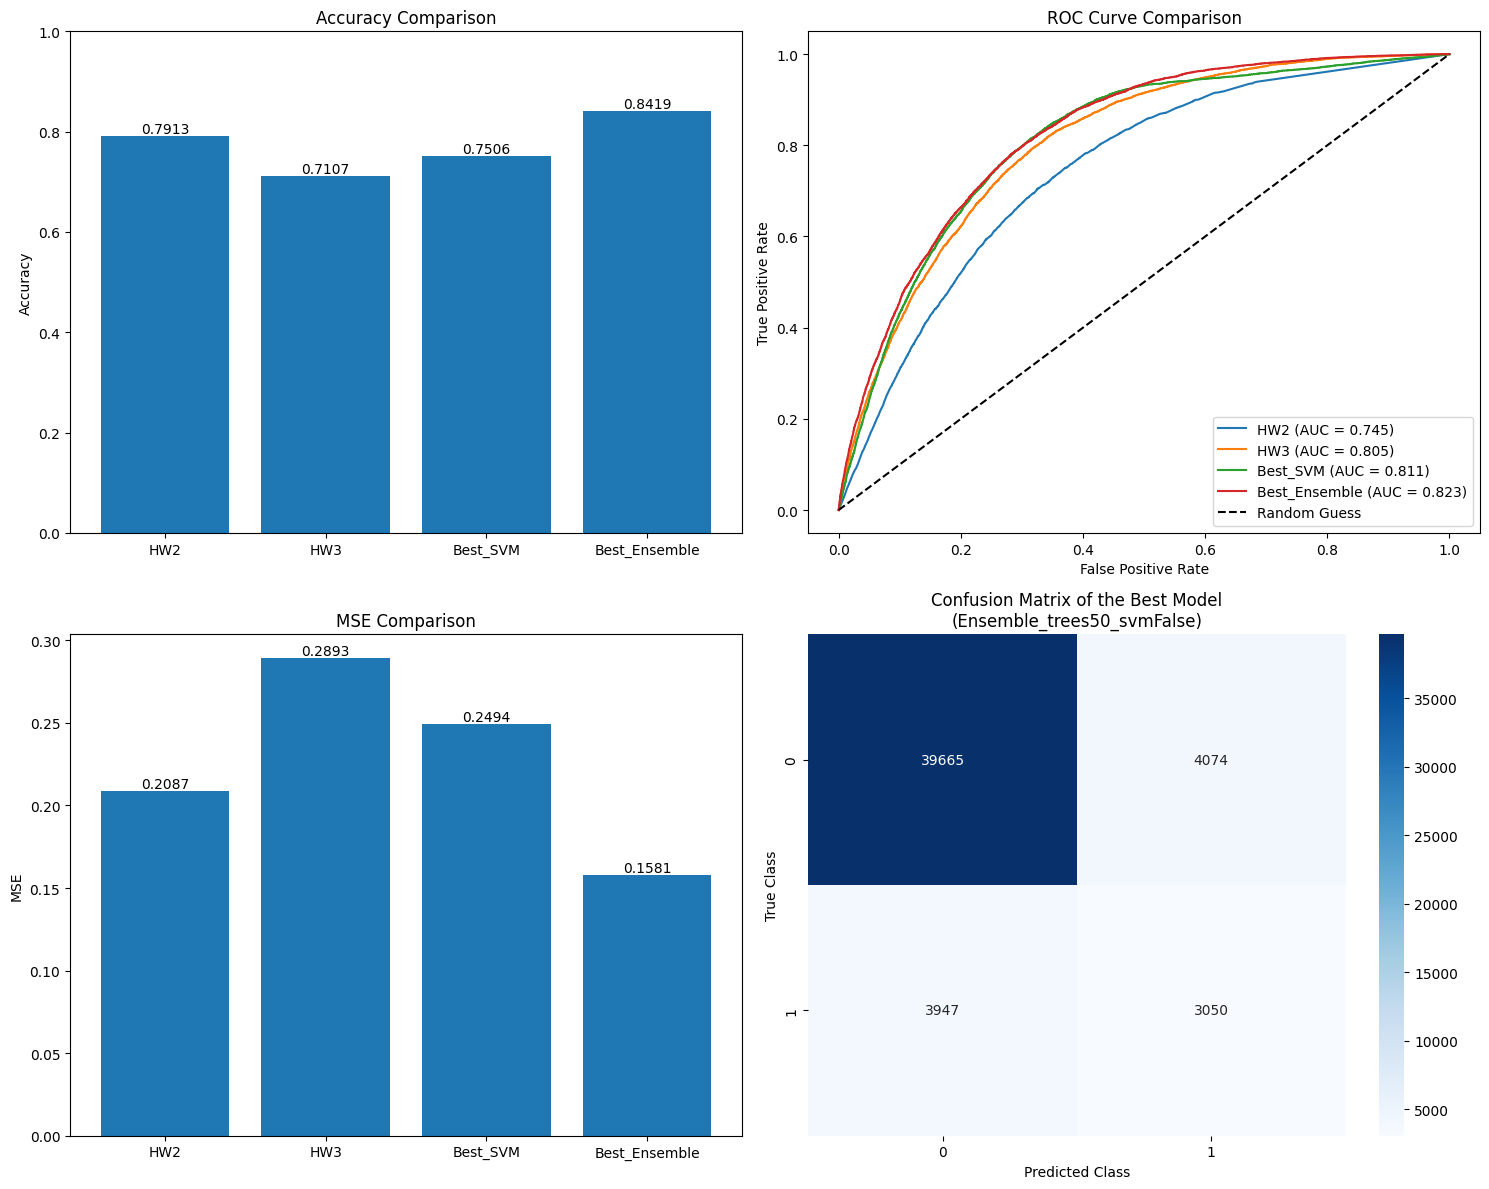


=== 詳細比較結果 ===

HW2:
準確率: 0.7913
MSE: 0.2087
AUC-ROC: 0.7448

HW3:
準確率: 0.7107
MSE: 0.2893
AUC-ROC: 0.8053

Best_SVM:
準確率: 0.7506
MSE: 0.2494
AUC-ROC: 0.8111

Best_Ensemble:
準確率: 0.8419
MSE: 0.1581
AUC-ROC: 0.8231

最佳模型是: Ensemble_trees50_svmFalse
最佳SVM配置: rbf
最佳Ensemble配置: ensemble_50_no_svm


In [28]:
# 在執行完所有方法後
plot_final_comparison(
  hw2_result,       # HW2的結果
  hw3_result,       # HW3的結果
  svm_linear,       # 線性SVM結果
  svm_rbf,          # RBF核SVM結果
  svm_poly,         # 多項式核SVM結果
  ensemble_50_no_svm,   # 50棵樹的Ensemble結果(不含SVM)
  ensemble_30_no_svm,  # 30棵樹的Ensemble結果(不含SVM)
)